<a href="https://colab.research.google.com/github/SamuelBFG/DL-studies/blob/master/Kaggle/Titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload();

Saving kaggle.json to kaggle.json


In [3]:
%%capture
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets list

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              215KB  2021-03-16 09:19:48            442  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   1GB  2021-02-18 10:08:27            436  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-02-17 16:10:44            374  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19            168  
fatiimaezzahra/famous-iconic-women                          Famous Iconic Wo

In [5]:
%%capture
! kaggle competitions download -c 'Titanic'

In [6]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
# Algorithms
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Data:

---



In [7]:
train_data = pd.read_csv("/content/train.csv")
test_data = pd.read_csv("/content/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Comments:
1.   891 training examples;
2.   11 features + target (12 total);

Data description:
1. **survival**:    If survived or not (1 or 0, respectively) 
2. **PassengerId**: Passengers Unique Id. 
3. **pclass**:    Ticket class     
4. **sex**:    Sex 
5. **Age**:    Age in years     
6. **sibsp**:    # of siblings / spouses aboard the Titanic     
7. **parch**:    # of parents / children aboard the Titanic     
8. **ticket**:    Ticket number     
9. **fare**:    Passenger fare     
10. **cabin**:    Cabin number     
11. **embarked**:    Port of Embarkation


In [9]:
train_data.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Rice, Master. Arthur",male,NaN,NaN,NaN,1601,NaN,G6,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


Comments:
1. **Age**, **Cabin** and **Embarked** have some missing values;
2. Only 38% of the training set survived Titanic;
3. Passenger ages varies between 0.4 and 80 years;

In [10]:
total = train_data.isnull().sum().sort_values(ascending=False) # Total NaN values
percent = round((train_data.isnull().sum()/train_data.isnull().count()*100), 1) # % NaN values feature/total
missing_data = pd.concat([total, percent], axis=1, keys=['Total', '%'])
print('Missing values (Age)')
missing_data.head(5)

Missing values (Age)


,Total,%
Cabin,687,77.1
Age,177,19.9
Embarked,2,0.2
Fare,0,0.0
Ticket,0,0.0


Comments:
1. 77% of Cabin feature is missing, we might desconsider it;

# Q: Which features contribute to survival rate?

In [11]:
train_data.columns.values

array(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'], dtype=object)

# Relationship between features:

---



## 1. **Age** and **Sex**

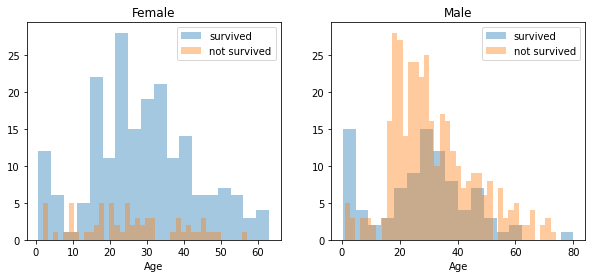

In [12]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
survived = 'survived'
not_survived = 'not survived'
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(10, 4))
women = train_data[train_data['Sex']=='female']
men = train_data[train_data['Sex']=='male']
ax = sns.distplot(women[women['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[0], kde =False)
ax = sns.distplot(women[women['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[0], kde =False)
ax.legend()
ax.set_title('Female')
ax = sns.distplot(men[men['Survived']==1].Age.dropna(), bins=18, label = survived, ax = axes[1], kde = False)
ax = sns.distplot(men[men['Survived']==0].Age.dropna(), bins=40, label = not_survived, ax = axes[1], kde = False)
ax.legend()
_ = ax.set_title('Male')

Comments:
1. Chance of survival is higher for male between age 30-35;
2. Chance of surival is higher for female between age 20-40; 
3. Prob. of survival very low for male between age 5-18;
4. In general, Female and infantes with high probability of survival

### Since there seem to be certain **ages**, which have increased odds of survival, turn it in groups would be interesting!!

## 2. Embarked, Pclass and Sex:

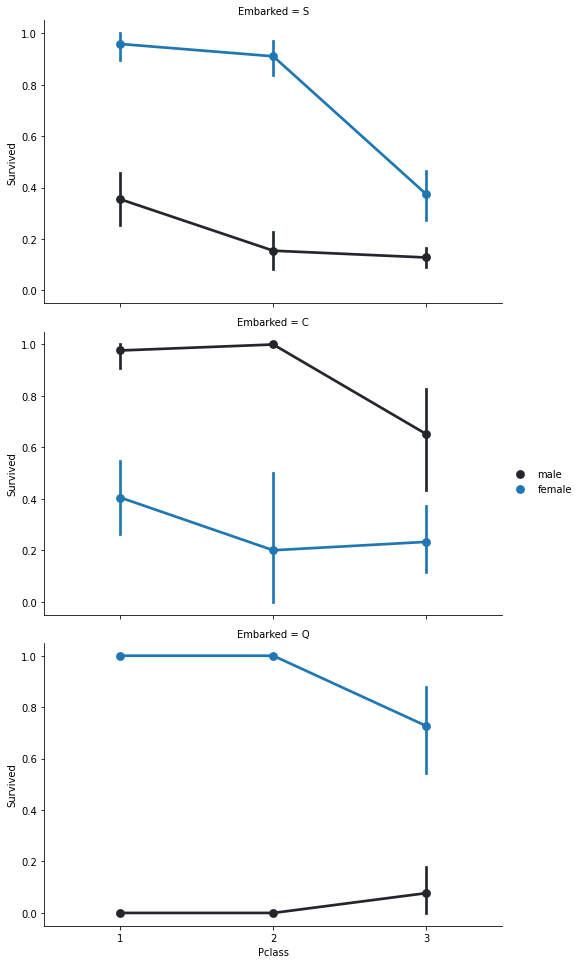

In [13]:
FacetGrid = sns.FacetGrid(train_data, row='Embarked', height=4.5, aspect=1.6)
FacetGrid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', palette=None,  order=None, hue_order=None )
FacetGrid.add_legend()

Comments:
1. Women on port Q and S have higher chance of survival;
2. Male on port C have higher chance of survival;

## 3. Pclass

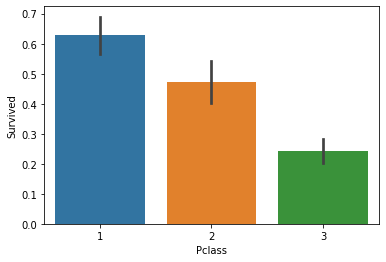

In [14]:
sns.barplot(x='Pclass', y='Survived', data=train_data)

Comments:

Clearly Pclass is contributing to a persons chance of survival!

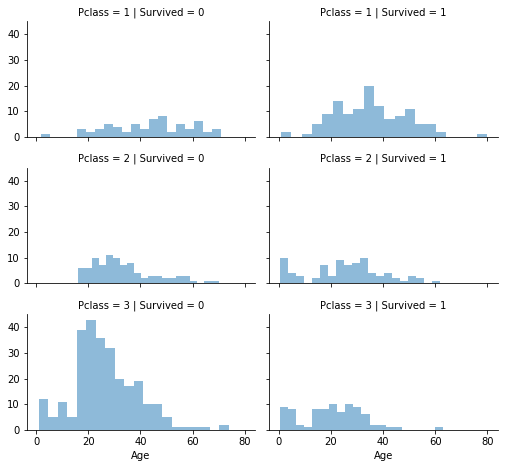

In [15]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass', height=2.2, aspect=1.6)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend();

## 4. SibSp and Parch:

Makes more sense as a combined feature, total number of relatives

In [16]:
data = [train_data, test_data]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)
train_data['not_alone'].value_counts()

1    537
0    354
Name: not_alone, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


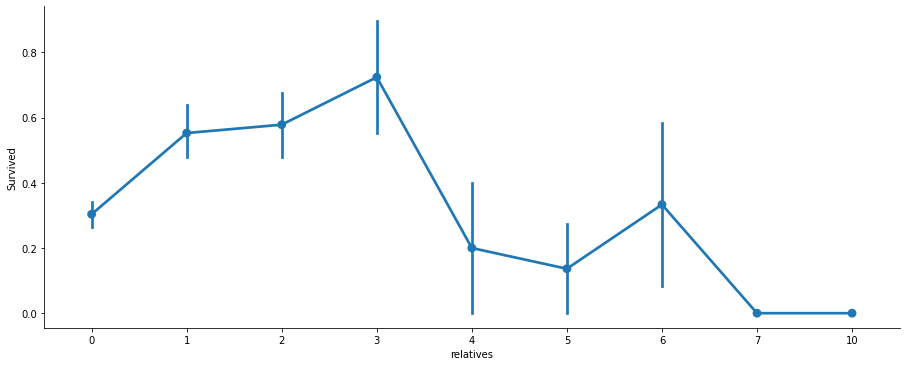

In [17]:
axes = sns.factorplot('relatives','Survived', 
                      data=train_data, aspect = 2.5)

Comments:
1. Higher chance of survival with 1 to 3 relatives.

# Data preprocessing:

---


## 1. Drop 'PassengerId' and 'Cabin'
Doesn't contribute to survival!

In [18]:
train_data = train_data.drop(['PassengerId'], axis=1)
train_data = train_data.drop(['Cabin'], axis=1)
test_data = test_data.drop(['Cabin'], axis=1)

## 2. Missing data:

• Age:

In [19]:
data = [train_data, test_data]

for dataset in data:
    mean = train_data["Age"].mean()
    std = test_data["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = train_data["Age"].astype(int)

• Embarked:

In [20]:
train_data['Embarked'].describe()

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [21]:
common_value = 'S'
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].fillna(common_value)

In [22]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Survived   891 non-null    int64  
 1   Pclass     891 non-null    int64  
 2   Name       891 non-null    object 
 3   Sex        891 non-null    object 
 4   Age        891 non-null    int64  
 5   SibSp      891 non-null    int64  
 6   Parch      891 non-null    int64  
 7   Ticket     891 non-null    object 
 8   Fare       891 non-null    float64
 9   Embarked   891 non-null    object 
 10  relatives  891 non-null    int64  
 11  not_alone  891 non-null    int64  
dtypes: float64(1), int64(7), object(4)
memory usage: 83.7+ KB


Comments:
1. All features with same dimension;
2. **Fare** is float;
3. 4 categorical features: **Name**, **Sex**, **Ticket**, **Embarked**

## 3. Treating categorical features

• **Fare**:

In [23]:
data = [train_data, test_data]

for dataset in data:
    dataset['Fare'] = dataset['Fare'].fillna(0)
    dataset['Fare'] = dataset['Fare'].astype(int)

• **Name**:

We will use the Name feature to extract the Titles from the **Name**, so that we can build a new feature out of that.

In [24]:
data = [train_data, test_data]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

• **Sex**:

Convert feature into numeric:

In [25]:
genders = {"male": 0, "female": 1}
data = [train_data, test_data]

for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

• **Ticket**:

In [26]:
train_data['Ticket'].describe()

count      891
unique     681
top       1601
freq         7
Name: Ticket, dtype: object

Dropping **Ticket**:

In [27]:
train_data = train_data.drop(['Ticket'], axis=1)
test_data = test_data.drop(['Ticket'], axis=1)

• **Embarked**:

In [28]:
ports = {"S": 0, "C": 1, "Q": 2}
data = [train_data, test_data]

for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

## 4. Creating new features

• **Age** times **class**:

In [29]:
data = [train_data, test_data]
for dataset in data:
    dataset['Age_Class'] = dataset['Age'] * dataset['Pclass']

• **Fare** per **Person**

In [30]:
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)
# Let's take a last look at the training set, before we start training the models.
train_data.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,relatives,not_alone,Title,Age_Class,Fare_Per_Person
0,0,3,0,22,1,0,7,0,1,0,1,66,3
1,1,1,1,38,1,0,71,1,1,0,3,38,35
2,1,3,1,26,0,0,7,0,0,1,2,78,7
3,1,1,1,35,1,0,53,0,1,0,3,35,26
4,0,3,0,35,0,0,8,0,0,1,1,105,8
5,0,3,0,22,0,0,8,2,0,1,1,66,8
6,0,1,0,54,0,0,51,0,0,1,1,54,51
7,0,3,0,2,3,1,21,0,4,0,4,6,4
8,1,3,1,27,0,2,11,0,2,0,3,81,3
9,1,2,1,14,1,0,30,1,1,0,3,28,15


In [31]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Survived         891 non-null    int64
 1   Pclass           891 non-null    int64
 2   Sex              891 non-null    int64
 3   Age              891 non-null    int64
 4   SibSp            891 non-null    int64
 5   Parch            891 non-null    int64
 6   Fare             891 non-null    int64
 7   Embarked         891 non-null    int64
 8   relatives        891 non-null    int64
 9   not_alone        891 non-null    int64
 10  Title            891 non-null    int64
 11  Age_Class        891 non-null    int64
 12  Fare_Per_Person  891 non-null    int64
dtypes: int64(13)
memory usage: 90.6 KB


Comments:

1. Features with same dimension and type

# Machine Learning models:

---

## 1. Slicing the data to k-fold validation:

In [32]:
X_train = train_data.drop("Survived", axis=1)
Y_train = train_data["Survived"]
X_test  = test_data.drop("PassengerId", axis=1).copy()

## 2. Algorithms:

• Stochastic Gradient Descent (SGD)

In [33]:
## Stochastic Gradient Descent (SGD):
sgd = SGDClassifier(max_iter=10, tol=None)
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)

sgd.score(X_train, Y_train)

acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)

• Random Forest:

In [34]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

Y_prediction = random_forest.predict(X_test)

random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

• Logistic Regression:

In [38]:
# Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, Y_train)

Y_pred = logreg.predict(X_test)

acc_log = round(logreg.score(X_train, Y_train) * 100, 2)

• K-Nearest Neighbor:

In [39]:
# KNN 
knn = KNeighborsClassifier(n_neighbors = 3) 
knn.fit(X_train, Y_train)  

Y_pred = knn.predict(X_test)  

acc_knn = round(knn.score(X_train, Y_train) * 100, 2)

• Gaussian Naive Bayes:

In [40]:
# Gaussian Naive Bayes
gaussian = GaussianNB() 
gaussian.fit(X_train, Y_train)  

Y_pred = gaussian.predict(X_test)  

acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)

• Perceptron: 

In [42]:
# Perceptron
perceptron = Perceptron(max_iter=100)
perceptron.fit(X_train, Y_train)

Y_pred = perceptron.predict(X_test)

acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)

• Linear Support Vector Machine:

In [43]:
# SVM
linear_svc = LinearSVC(max_iter=10000)
linear_svc.fit(X_train, Y_train)

Y_pred = linear_svc.predict(X_test)

acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


• Decision Tree:

In [44]:
# Decision Tree
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_train, Y_train)  

Y_pred = decision_tree.predict(X_test)  

acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)

## 3. Looking for the best ML model:

In [45]:
results = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 
              'Decision Tree'],
    'Score': [acc_linear_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_decision_tree]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')
result_df.head(9)

,Model
Score,
96.86,Random Forest
96.86,Decision Tree
84.74,KNN
81.71,Support Vector Machines
81.26,Logistic Regression
80.81,Naive Bayes
76.21,Perceptron
71.38,Stochastic Gradient Decent


# Applying K-fold Cross Validation on the best model:

---


• K = 10

In [ ]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=100)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.73333333 0.85393258 0.75280899 0.80898876 0.83146067 0.84269663
 0.84269663 0.78651685 0.82022472 0.79775281]
Mean: 0.8070411985018726
Standard Deviation: 0.03794316198790456


Comments:

1. RandomForest has a average of accuracy of 80%, with standard deviation of 3.7%;
2. Model accuracy can differ +- 3.7%

# Using Deep Learning

---

In [46]:
print("shape of X_train",X_train.shape)
print("Shape of Y_train",Y_train.shape)
print("Shape of x_test",X_test.shape)

shape of X_train (891, 12)
Shape of Y_train (891,)
Shape of x_test (418, 12)


In [48]:
import tensorflow as tf
import keras 
from keras.layers import Dense, Dropout, Input
from keras.models import Sequential

In [102]:
model = Sequential()
model.add(Dense(units = 32, input_shape = (12,), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu', kernel_initializer = 'he_normal', use_bias = False))

# model.add(Dense(units = 128, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
# model.add(Dropout(0.1))
# model.add(Dense(units = 64, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
# model.add(Dropout(0.1))
model.add(Dense(units = 32, activation = 'relu'))
# model.add(Dropout(0.15))
# model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 8, activation = 'relu',kernel_initializer = 'he_normal', use_bias = False))
model.add(Dense(units =1 , activation = 'sigmoid'))


model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 32)                416       
_________________________________________________________________
dense_45 (Dense)             (None, 64)                2048      
_________________________________________________________________
dense_46 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_47 (Dense)             (None, 8)                 256       
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 9         
Total params: 4,809
Trainable params: 4,809
Non-trainable params: 0
_________________________________________________________________


In [112]:
model.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['acc'])

history = model.fit(X_train, Y_train, batch_size = 32, verbose = 2, epochs = 50)

Epoch 1/50
28/28 - 0s - loss: 0.3706 - acc: 0.8339
Epoch 2/50
28/28 - 0s - loss: 0.3565 - acc: 0.8429
Epoch 3/50
28/28 - 0s - loss: 0.3489 - acc: 0.8418
Epoch 4/50
28/28 - 0s - loss: 0.3402 - acc: 0.8485
Epoch 5/50
28/28 - 0s - loss: 0.3404 - acc: 0.8496
Epoch 6/50
28/28 - 0s - loss: 0.3424 - acc: 0.8530
Epoch 7/50
28/28 - 0s - loss: 0.3525 - acc: 0.8361
Epoch 8/50
28/28 - 0s - loss: 0.3428 - acc: 0.8406
Epoch 9/50
28/28 - 0s - loss: 0.3460 - acc: 0.8406
Epoch 10/50
28/28 - 0s - loss: 0.3526 - acc: 0.8451
Epoch 11/50
28/28 - 0s - loss: 0.3405 - acc: 0.8496
Epoch 12/50
28/28 - 0s - loss: 0.3417 - acc: 0.8429
Epoch 13/50
28/28 - 0s - loss: 0.3478 - acc: 0.8395
Epoch 14/50
28/28 - 0s - loss: 0.3363 - acc: 0.8485
Epoch 15/50
28/28 - 0s - loss: 0.3369 - acc: 0.8496
Epoch 16/50
28/28 - 0s - loss: 0.3418 - acc: 0.8418
Epoch 17/50
28/28 - 0s - loss: 0.3351 - acc: 0.8507
Epoch 18/50
28/28 - 0s - loss: 0.3390 - acc: 0.8519
Epoch 19/50
28/28 - 0s - loss: 0.3352 - acc: 0.8451
Epoch 20/50
28/28 - 0

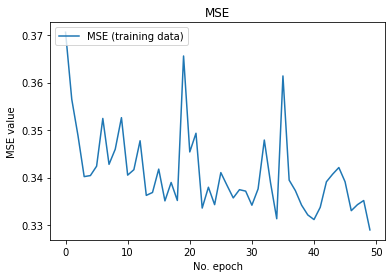

In [113]:
plt.plot(history.history['loss'], label='MSE (training data)')
# plt.plot(history.history['val_acc'], label='MSE (validation data)')
plt.title('MSE')
plt.ylabel('MSE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [53]:
predict = model.predict(X_test)
#since we have use sigmoid activation function in output layer
predict = (predict > 0.5).astype(int).ravel()
print(predict)

[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 1 1 0 1 0 1 1 1 0 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 1 1 0 1 1
 1 1 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0
 1 1 1 1 0 0 1 0 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0
 1 0 1 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 0 1 1 1
 0 1 0 0 0 0 1 1 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 1 1 1 0 1 0
 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 1 0 0 0 1 0 1 0 1 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0
 1 0 0 0 0 0 0 0 1 1 0 1 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 1 0 0 0 1 0 0
 1 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 1 0 0 1 1 0
 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 0 0 0
 1 1 0 1 1 0 0 1 0 0 1]


In [54]:
model.metrics_names

['loss', 'acc']

In [57]:
import matplotlib.pyplot as plt
plt.plot(model['acc'])

TypeError: ignored